In [3]:
import torch
import torch.nn as  nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import math
import time
import os
from skimage import io, transform
import PIL
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models


from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

In [9]:
curdir = os.getcwd()
data_dir = curdir + '/ISICdataNewAndLovely'
picture_dir = data_dir+'/'+'jpeg'+'/train'+'/'


#New version of labelscsv

In [10]:
labelscsv = data_dir+'/train.csv'
train_df = pd.read_csv(labelscsv)[:]
print(train_df.head())
trains = os.listdir(picture_dir)
train_df = train_df.isin({"image_name": trains})
print(train_df.head())
np.mean(train_df.iloc[:,7])

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  
   image_name  patient_id    sex  age_approx  anatom_site_general_challenge  \
0       False       False  False       False                          False   
1       False       False  False       False                          False   
2       False       False  False       Fal

0.0

In [11]:

#weights_dir = 
working_dir = './content'
global_batch_size = 64 #32
workers = 2 #workers not defined properly with init_fn
np.random.seed(10)
print(os.listdir(picture_dir)[0:4])



#print(max(train_df.iloc[:,0]))
train_df.head()

#print(os.listdir(f'{data_dir}/train.csv')[0:4])


np.mean(train_df.iloc[:,7])

['ISIC_8740331.jpg', 'ISIC_1037945.jpg', 'ISIC_0388873.jpg', 'ISIC_1665118.jpg']


0.0

#Set up transforms and dataset

In [12]:
# Transforms: using mean, std's from imagenet - should be from dataset. 

img_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

img_transforms_valid = transforms.Compose([transforms.Resize(255),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])])

In [13]:
class PawpularityDataset(Dataset):
    """Dataset connecting animal images to the score and annotations"""

    def __init__(self, csv_file, img_dir, transform=transforms.ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.annotations_csv = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir,
                                self.annotations_csv.iloc[idx, 0])

        # load each image in PIL format for compatibility with transforms
        image = PIL.Image.open(img_name + '.jpg')
        
        # Column 7 has the scores
        score = np.array(self.annotations_csv.iloc[idx, 7])
        score = torch.tensor(score) #view()score = torch.tensor(score.astype('float')).to(torch.float32)

        # Apply the transforms
        image = self.transform(image)

        sample = [image, score]
        return sample


#Set up model

In [14]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm1(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
print(ResNet50(2))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

#Cross Validation

In [15]:
# Load and set up the final training and validation dataset (use different transforms)
# Return a list of train/valid # Load and set up the final training and validation dataset (use different transforms)
# Return a list of train/valid dataloaders with different train/test splits for cross validation
from sklearn.model_selection import KFold

# Create two versions of the dataset with and without image augmentation
augmented_data = PawpularityDataset(labelscsv, picture_dir, transform=img_transforms)
base_transform_data = PawpularityDataset(labelscsv, picture_dir, transform=img_transforms_valid)

def get_cv_dataloaders(augmented_data, base_transform_data, folds=5, cv_shuffle=True, rands=10):
    
    num_images = len(augmented_data)
    indices = list(range(num_images))
    
    dataloaders = []
    
    # use sklearn kfold to split into random training/validation indices
    cv = KFold(n_splits=folds, random_state=rands, shuffle=cv_shuffle)
    for train_idx, valid_idx in cv.split(indices):
        # define samplers for obtaining training and validation batches
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        # create dataloaders using the cv indexes
        train_loader = torch.utils.data.DataLoader(augmented_data, batch_size=global_batch_size,
                                                   sampler=train_sampler, num_workers=workers,
                                                   pin_memory=True) 
        # sample the validation dataset from a separate dataset the doesn't include the image aug transformations.
        valid_loader = torch.utils.data.DataLoader(base_transform_data, batch_size=global_batch_size,
                                                   sampler=valid_sampler, num_workers=workers,
                                                   pin_memory=True) 

        print('Train length: ', len(train_loader)*global_batch_size)
        print('Valid length: ', len(valid_loader)*global_batch_size)
        
        dataloaders.append((train_loader, valid_loader))
        
    return dataloaders

In [16]:
cv_dataloaders = get_cv_dataloaders(augmented_data=augmented_data, 
                                base_transform_data=base_transform_data,
                                folds=3, 
                                cv_shuffle=True)
print(cv_dataloaders)

Train length:  22144
Valid length:  11072
Train length:  22144
Valid length:  11072
Train length:  22144
Valid length:  11072
[(<torch.utils.data.dataloader.DataLoader object at 0x7fed30460fd0>, <torch.utils.data.dataloader.DataLoader object at 0x7fed30460370>), (<torch.utils.data.dataloader.DataLoader object at 0x7fed3037bc40>, <torch.utils.data.dataloader.DataLoader object at 0x7fedaf5342b0>), (<torch.utils.data.dataloader.DataLoader object at 0x7fed2eb83340>, <torch.utils.data.dataloader.DataLoader object at 0x7fed2eb83e50>)]


In [17]:
# Batch size of 64
tl = cv_dataloaders[0][1]

print(tl)
images, scores = next(iter(tl))

print(next(iter(images)).shape)
print(images.shape)
print(scores.shape)

torch.Size([3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64])


#Look at images

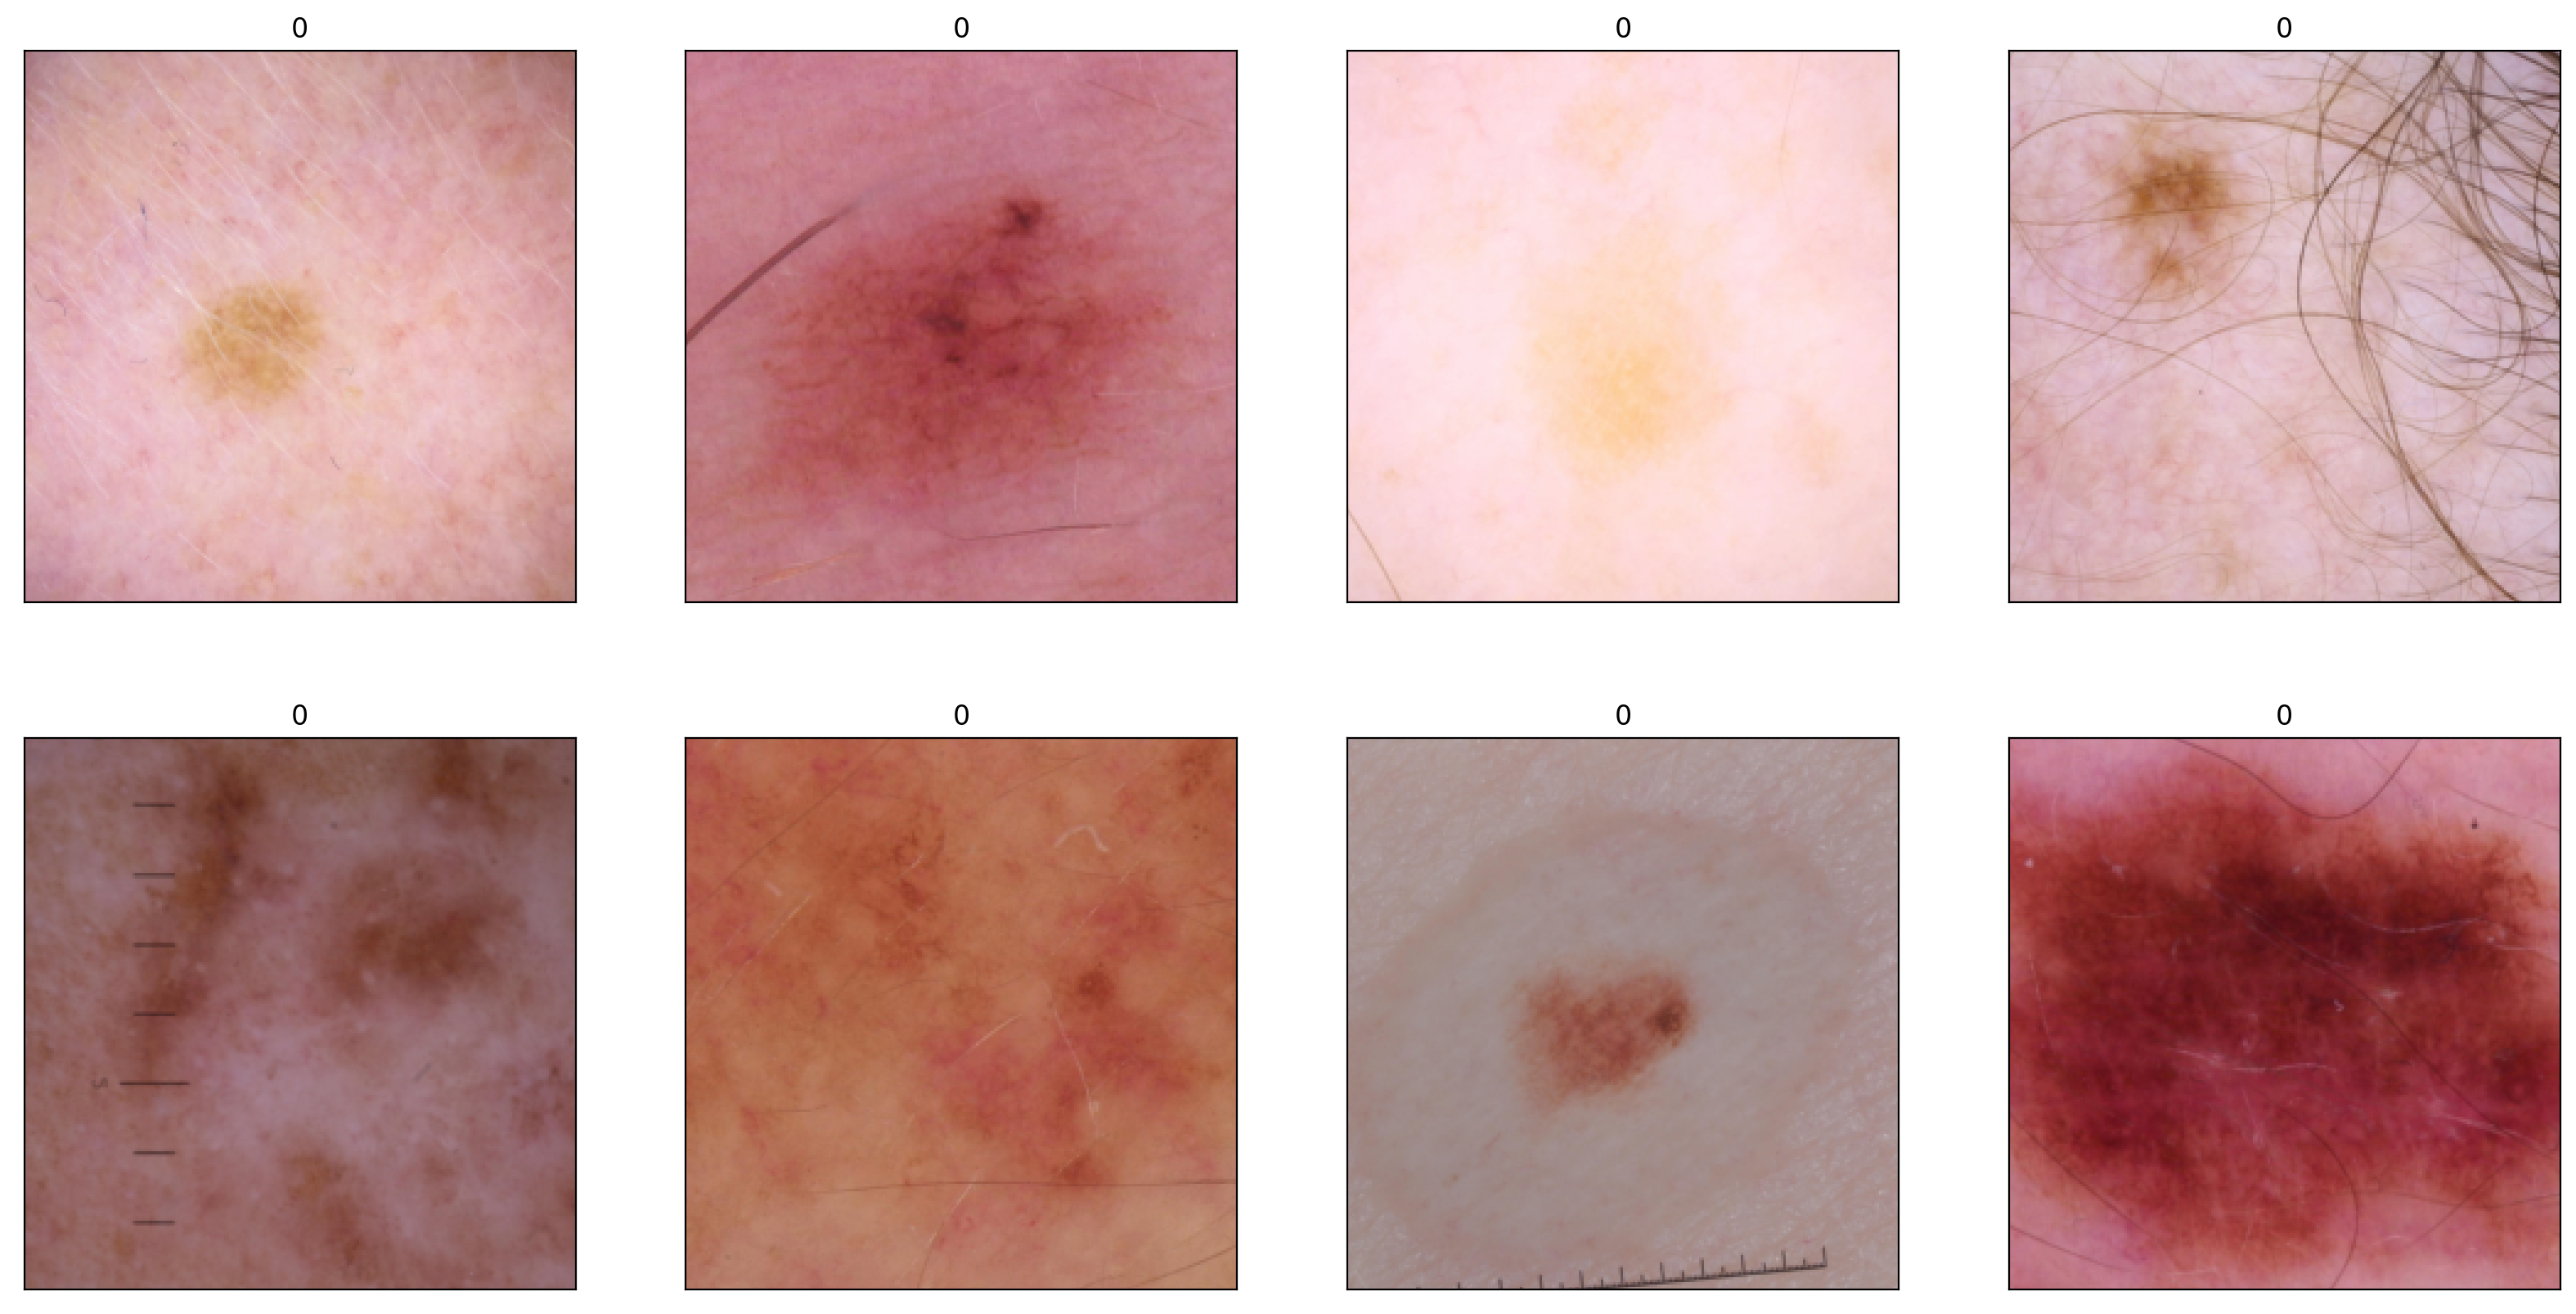

In [18]:
 #Helper function to unnormalize and plot images
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image * np.array((0.229, 0.224, 0.225)).reshape(3, 1, 1) + np.array((0.485, 0.456, 0.406)).reshape(3, 1, 1)
    img = (image * 255).astype(np.uint8) # unnormalize
    

    return plt.imshow(np.transpose(img, (1, 2, 0)))

im_numpy = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))
# display 8 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    im_convert(images[idx])
    ax.set_title(scores[idx].item())



In [19]:
model = ResNet50(2).to('cuda')
def initialize_optimizer(starting_lr, lambd):
    
    # Loss function using MSE (the goal)
    criterion = nn.CrossEntropyLoss()

    #Adam with weightdecay
    optimizer = optim.AdamW(model.parameters(), lr=starting_lr)#, weight_decay=lambd)

    # Learning rate decay
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [1, 2, 6], gamma=0.5)
    
    return criterion, optimizer, scheduler

criterion, optimizer, scheduler = initialize_optimizer(0.000025, 100)



RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

#Test on single forward pass.

In [ ]:
images, scores = next(iter(cv_dataloaders[0][1]))
images = images.cuda()
scores = scores.cuda()
with torch.no_grad():
    train_loss = 0.0
    output = model(images) # convert sigmoid output to pawpularity scale
    print(output.shape)
    print(scores.shape)
    loss = criterion(output, scores)
    RMSE = math.sqrt(loss.item()/global_batch_size)

#print(scores.dtype)
#print(output.dtype)
print('Starting Prediction: ', torch.mean(output))
print('Starting RMSE: ', RMSE)
print('Prediction Standard Deviation: ', torch.std(output))

#Training and validation loop

In [ ]:
# Training and validation loop

def train_validation_loop(fold, model, train_loader, valid_loader, train_on_gpu, n_epochs=3):

    if train_on_gpu:
        model.cuda()

    valid_loss_min = np.Inf # track change in validation loss

    train_losses, valid_losses = [], []

    for epoch in range(1, n_epochs):

        start = time.time()
        current_lr = scheduler.get_last_lr()[0]

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # Stop training the convolutional layers after a certain point
        #if epoch > 4:
        #    for param in model.layer3.parameters():
        #        param.requires_grad = False
        
        #if epoch > 5:
        #    for param in model.layer4.parameters():
        #        param.requires_grad = False

        ###################
        # train the model #
        ###################
        # put in training mode (enable dropout)
        model.train()
        for images, scores in train_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, scores = images.cuda(), scores.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images) # multiply by 100 the sigmoid output to 0-100 pawpularity scale
            #print(output.dtype)
            #print(scores.dtype)
            # calculate the batch loss
            loss = criterion(output, scores)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

        ######################    
        # validate the model #
        ######################
        # eval mode (no dropout)
        print("val")
        model.eval()
        with torch.no_grad():
            for images, scores in valid_loader:
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    images, scores = images.cuda(), scores.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(images) # multiply by 100 the sigmoid output to 0-100 pawpularity scale
                # calculate the batch loss
                loss = criterion(output, scores)
                # update average validation loss 
                valid_loss += loss.item()

        # calculate RMSE
        train_loss = math.sqrt(train_loss/len(train_loader.sampler))
        valid_loss = math.sqrt(valid_loss/len(valid_loader.sampler))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # increment learning rate decay
        scheduler.step()

        # print training/validation statistics 
        # print(f'Epoch: {e}, {float(time.time() - start):.3f} seconds, lr={optimizer.lr}')
        print('Epoch: {}, time: {:.1f}s, lr: {:.7f} \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(
            epoch, float(time.time() - start), current_lr, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            model_name = f'{working_dir}pawpularity_best_model_fold{fold}.pt'
            torch.save(model.state_dict(), model_name)
            valid_loss_min = valid_loss
        
        # Stop early if the min epochs is satisfied and score isn't improving
        if valid_loss > valid_loss_min+0.04 and epoch >= n_epochs:
            break
    
    # Plot the losses
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(list(range(0, len(train_losses))), train_losses[0:])
    ax.plot(list(range(0, len(valid_losses))), valid_losses[0:]);
    print(f'best score: {valid_loss_min}')
        
    return (model_name, valid_loss_min)

# check if CUDA is available and set the training device

train_on_gpu = torch.cuda.is_available()
device = torch.cuda.get_device_name()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print(f'CUDA is available!  Training on GPU {device}...')



#Start training and validation

In [ ]:
# Train for all of the cv folds

cv_folds = 3
epochs = 7
starting_lr = 0.00005
lambd = 7 # Regularization 

cv_dataloaders = get_cv_dataloaders(augmented_data=augmented_data, 
                                    base_transform_data=base_transform_data,
                                    folds=cv_folds, 
                                    cv_shuffle=True)

saved_models = []

for i, (train_loader, valid_loader) in enumerate(cv_dataloaders):
    print('Starting Fold', i)
    
    # Reset the model and schedulers for each new dataset
    criterion, optimizer, scheduler = initialize_optimizer(starting_lr=starting_lr, lambd=lambd)
    
    # Run the training loop and add the best model's filepath
    saved_models.append(train_validation_loop(i, model, train_loader, valid_loader, train_on_gpu, n_epochs=epochs))
    
    if i >= 2:
       break
    print('\n')
